# Proyecto 2 Mineria de Datos
## Predicción de Indices de Precios al Consumidor
---
**Integrantes**
- Maria Marta Ramirez Gil
- Gustavo Andres Gonzalez Pineda 
- Diego Alberto Leiva Pérez 
- José Pablo Orellana Orellana 
- Gabriel Estuardo García Donis 
---

**Importar Librerias**

In [81]:
import os

# Manipulacion de datos
import pandas as pd
import numpy as np

# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Normalizacion de strings
import unidecode

# Libreria re para manejo de expresiones regulares
import re

# Librerias para pre procesamiento de datos
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Librerias para regresion lineal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Libreria de metricas
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

**Cargar el Dataset**

In [82]:
dataframe = pd.read_csv('IPC_CLEAN.csv')

**Visualizar estructura e información general del dataset**

In [83]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42139 entries, 0 to 42138
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   codigo       42139 non-null  int64  
 1   descripcion  42139 non-null  object 
 2   pais         42139 non-null  float64
 3   region1      42139 non-null  float64
 4   region2      42139 non-null  float64
 5   region3      42139 non-null  float64
 6   region5      42139 non-null  float64
 7   region6      42139 non-null  float64
 8   region7      42139 non-null  float64
 9   region8      42139 non-null  float64
 10  fecha        42139 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 3.5+ MB


In [84]:
for value, name in zip(dataframe.shape,['Registros', 'Variables']):
    print(f'Cantidad de {name}: {value}')

Cantidad de Registros: 42139
Cantidad de Variables: 11


In [85]:
dataframe.head()

,codigo,descripcion,pais,region1,region2,region3,region5,region6,region7,region8,fecha
0,0,indice general,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
1,1,alimentos y bebidas no alcoholicas ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
2,111101,arroz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
3,111201,harina ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
4,111202,maiz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01


**Variables Identificadas:**
- codigo: Identificador numérico para cada producto o categoría de productos.
- descripcion: Detalle sobre el producto o categoría de productos al que se refiere el índice de precios.
- pais: Valor representativo para todo el país
- region_1: Valor representativo de la región Metropolitana.
- region_2: Valor representativo de la región Norte.
- region_3: Valor representativo de la región Nororiental.
- region_5: Valor representativo de la región Central.
- region_6: Valor representativo de la región Suroccidental.
- region_7: Valor representativo de la región Noroccidental.
- region_8: Valor representativo de la región Petén.
---

## Selección de Variable Respuesta

La variable de respuesta seleccionada es la variable de `pais`.

Esta variable representa el Índice de Precios al Consumidor (IPC) a nivel nacional para Guatemala. Elegir esta variable permite modelar y predecir la tendencia general de la inflación y los cambios de precios en todo el país. Esto es útil para entender la economía a gran escala y para formular políticas económicas que impacten a toda la nación.

Sin embargo, dada la estructura del dataset es posible realizar otro tipo de seleccion y predicciones de variables, las cuales se lisan a continuación:

- Variable `region_N` (donde N puede ser cualquier número de 1 a 8, dependiendo de la región de interés) Cada columna `region_N` representa el IPC para una región específica de Guatemala. Seleccionar una de estas variables permite realizar predicciones específicas para una región determinada, lo cual es crucial para políticas regionales y para entender cómo diferentes partes del país se comportan en términos de cambios en los precios. Esto puede ayudar a identificar regiones con necesidades económicas particulares o con dinámicas de mercado únicas.
- Variable filtrada por `codigo`. En este caso al filtrar por un producto o categoría específicos, y luego seleccionar `pais` como variable de respuesta, podemos predecir cómo el IPC de ese producto o categoría particular se comporta a nivel nacional.

---

### Preprocesamiento de datos

**Conversión de Fecha a dato numérico**

Es necesario convertir la columna de fecha (variable categórica) a dato numérico ya que la fecha es la variable que indica como el IPC cambia a lo largo del tiempo. Sin esta conversión no es posible tomar el factor tiempo en consideración dentro del modelo, lo cual puede provocar predicciones erroneas.

In [86]:
# Realizar una copia del dataframe
data = dataframe.copy()

# Convertir 'fecha' a años y meses asi son datos numericos
data['fecha'] = pd.to_datetime(data['fecha'])
data['anio'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month

# Mostrar el dataframe con las nuevas columnas
data.head()

,codigo,descripcion,pais,region1,region2,region3,region5,region6,region7,region8,fecha,anio,mes
0,0,indice general,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
1,1,alimentos y bebidas no alcoholicas ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
2,111101,arroz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
3,111201,harina ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
4,111202,maiz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12


## Modelos

### Modelo Split aleatorio con Variable Respuesta `IPC Nacional`

**División del Dataset**

In [87]:
# Features and target
X = data[['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y = data['pais']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 44.10251550303405
R2 Score: 0.9045125218850901


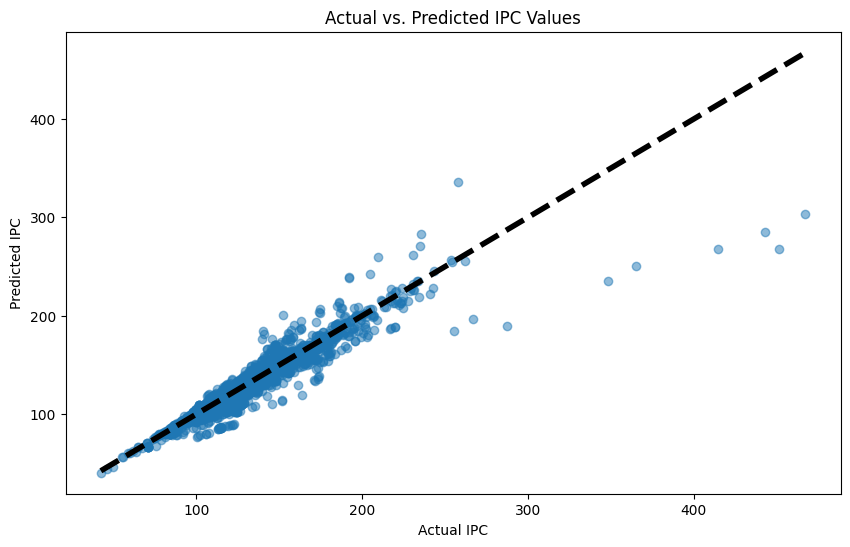

In [88]:
# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted IPC Values')
plt.xlabel('Actual IPC')
plt.ylabel('Predicted IPC')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

### Modelo Split basado en tiempo con Variable Respuesta `IPC Nacional`

**División del Dataset**

In [89]:
# Sort the data by date
data_sorted = data.sort_values(by='fecha')

# Define a split point for the last 20% of the data
split_index = int(len(data_sorted) * 0.8)

# Split the data into training and testing sets based on the time index
X_train_time = data_sorted.iloc[:split_index][['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y_train_time = data_sorted.iloc[:split_index]['pais']
X_test_time = data_sorted.iloc[split_index:][['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y_test_time = data_sorted.iloc[split_index:]['pais']

# Initialize and train the linear regression model on the time-split data
model_time = LinearRegression()
model_time.fit(X_train_time, y_train_time)

# Predictions and model evaluation on the time-split data
y_pred_time = model_time.predict(X_test_time)
mse_time = mean_squared_error(y_test_time, y_pred_time)
r2_time = r2_score(y_test_time, y_pred_time)

print(f'Mean Squared Error (Time-Split Data): {mse_time}')
print(f'R2 Score (Time-Split Data): {r2_time}')

Mean Squared Error (Time-Split Data): 41.828676611172675
R2 Score (Time-Split Data): 0.9214473288879494


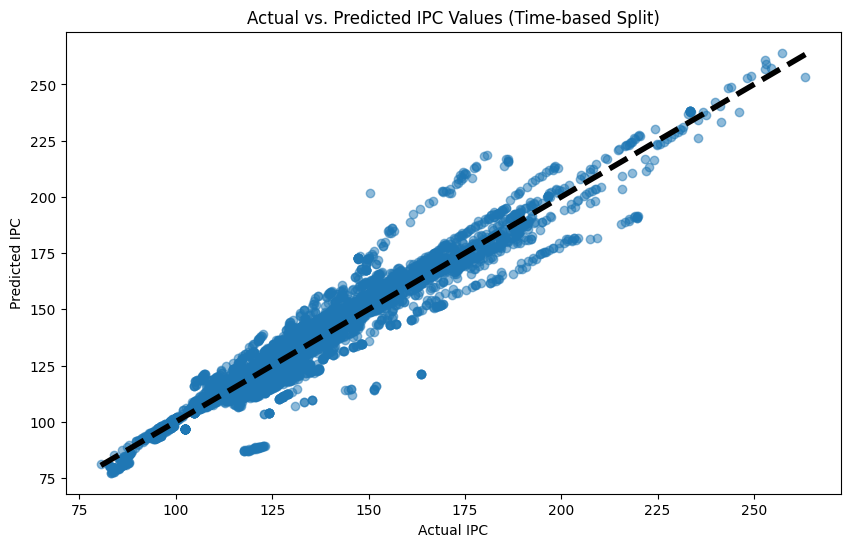

In [90]:
# Scatter plot of Actual vs. Predicted for time-based split
plt.figure(figsize=(10, 6))
plt.scatter(y_test_time, y_pred_time, alpha=0.5)
plt.title('Actual vs. Predicted IPC Values (Time-based Split)')
plt.xlabel('Actual IPC')
plt.ylabel('Predicted IPC')
plt.plot([y_test_time.min(), y_test_time.max()], [y_test_time.min(), y_test_time.max()], 'k--', lw=4)
plt.show()